# Week 5 - Regression models

**IMPORTANT NOTICE**: In this notebook, we will use Python PANDAS package. Besides installing it (you may already have it), note that it is a very powerful tool for data cleaning and data preparation. You will see some examples of this. If you never worked with it, we recommend you to take an hour or so to take a look at the concept of Dataframe, and main methods used. Feel free to use "42184-Data Sciences and GIS for Mobility" materials about Pandas. 

## Part 2.1 -  Modelling taxi pickups in Wall Street (NYC)

In this notebook, we will consider the problem of modelling taxi pickups in Wall Street (see area in the map below).

<img src="wall_street.png">

But before we go into details, the usual imports...

In [28]:
import numpy as np
import pandas as pd   # We import Pandas!
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils
import imp
imp.reload(pystan_utils)

import torch

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import config_enumerate, MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

Lets start by loading the dataset. In order to let you focus on the probabilistic modelling aspects, we already prepared the raw GPS taxi data for you and extended it with additional information about the weather conditions.

In [3]:
# load csv (original dataset is by 30min intervals, we want 1h intervals) into a Pandas Dataframe
df = pd.read_csv("pickups+weather_wallstreet.csv")

# look at the first few lines of the loaded dataset
df.head()

,datetime,pickups,date,min_temp,max_temp,wind_speed,wind_gust,visibility,pressure,precipitation,snow_depth,fog,rain_drizzle,snow_ice,thunder
0,2009-01-01 00,47,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
1,2009-01-01 01,74,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
2,2009-01-01 02,79,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
3,2009-01-01 03,57,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
4,2009-01-01 04,46,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0


Before we do anything with the data, it is always a good idea to try to visualize it.

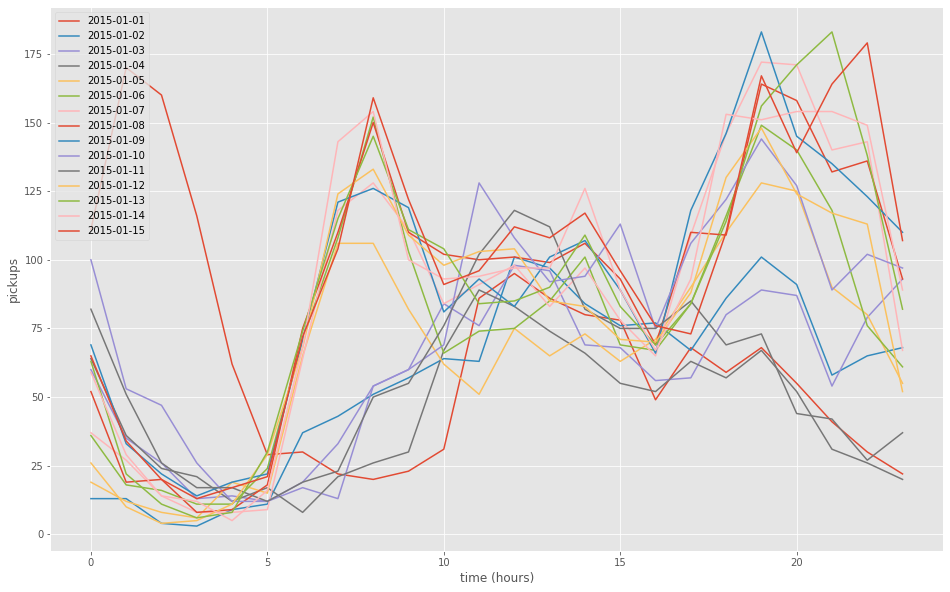

In [4]:
# visualize first 15 days of January 2015
dates = []
for day in range(1,16):   # we will search for days 1-15
    date = "2015-01-%.2d" % (day,)
    dates.append(date)
    plt.plot(df[df.date == date]["pickups"].values)   # select lines with corresponding date
plt.xlabel("time (hours)")
plt.ylabel("pickups")
plt.legend(dates);

We will now preprocess the dataset. Particularly, we will filter the data to keep only data from 2015, and we will also extract some relevant features from the dates (e.g. day of the week and hour of the day).

In [5]:
# convert datetime column to datetime object
df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d")

# filter: use only data from 2015
df = df[df.datetime.dt.year == 2015]

# add column with day of week (dow) and time of day (tod)
df["dow"] = df["datetime"].dt.weekday
df["tod"] = df["datetime"].dt.hour

df.head()  #let's see how the dataframe looks like now (notice new columns!)

,datetime,pickups,date,min_temp,max_temp,wind_speed,wind_gust,visibility,pressure,precipitation,snow_depth,fog,rain_drizzle,snow_ice,thunder,dow,tod
52584,2015-01-01 00:00:00,111,2015-01-01,27.0,39.0,5.3,25.1,10.0,1014.6,0.0,0.0,0,0,0,0,3,0
52585,2015-01-01 01:00:00,170,2015-01-01,27.0,39.0,5.3,25.1,10.0,1014.6,0.0,0.0,0,0,0,0,3,1
52586,2015-01-01 02:00:00,160,2015-01-01,27.0,39.0,5.3,25.1,10.0,1014.6,0.0,0.0,0,0,0,0,3,2
52587,2015-01-01 03:00:00,116,2015-01-01,27.0,39.0,5.3,25.1,10.0,1014.6,0.0,0.0,0,0,0,0,3,3
52588,2015-01-01 04:00:00,62,2015-01-01,27.0,39.0,5.3,25.1,10.0,1014.6,0.0,0.0,0,0,0,0,3,4


We wish to model the number of taxi pickups in the Wall Street area as a function of features such as the day of the week, time of the day and weather condtitions. 




However, the number of pickups is clearly not a linear function of these variables directly! For example, for time of the day - a discrete variable ranging from 0 to 23 - there's no reason to believe pickups to be proportional to the hour number! 

In order to allow for non-linear relationships, we shall consider a 1-of-K encoding of the day of week and time of day variables.

The Pandas method "get_dummies" exists just for that!

In [6]:
# a short demo of the one_of_K_enc function
enc=np.array(pd.get_dummies(df["tod"]))
print(enc.shape)
print(enc[:50,:]) # first 50 rows of tod. Notice that ech row has 24 numbers (1 one and 23 zeros) 

(8760, 24)
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


So, let's do it for the two variables:

In [7]:
# prepare matrix with time features
X_time = np.concatenate([pd.get_dummies(df[x]) for x in ["dow", "tod"]], axis=1)
print(X_time.shape)

(8760, 31)


In [8]:
# prepare matrix with weather features
X_weather = df[["min_temp","max_temp","wind_speed","wind_gust",
                "visibility","pressure","precipitation","snow_depth",
                "fog","rain_drizzle","snow_ice"]].as_matrix()
X_weather = df[["min_temp","snow_depth","precipitation"]].as_matrix()
print(X_weather.shape)

(8760, 3)


/Users/shgm/Projects/42186-model-based-machine-learning/env_mbml/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/Users/shgm/Projects/42186-model-based-machine-learning/env_mbml/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [9]:
# create matrix with time and weather features
X = np.concatenate([X_time, X_weather], axis=1)
print(X.shape)

# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

(8760, 34)


In [10]:
# prepare vector of target taxi pickups
y = df["pickups"].as_matrix()

# standardize pickups
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std
print(y.shape)

(8760,)


/Users/shgm/Projects/42186-model-based-machine-learning/env_mbml/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


We now have all our data prepared and standardized. Note that it is often very important to have your data properly standardized (can you think of potential problems if your data is not standardized?).

The X matrix now contain all the input data for the model, and the y vector contains all the corresponding targets (number of taxi pickups).

The next step is to split our data into a train and test set. Alternatively, we could have used something like cross-validation, but for the sake of simplicity, a train/test split will do just fine for this example.

In [11]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_time_train = X_time[ix_train,:]
X_time_test = X_time[ix_test,:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 5781
num test: 2979


A crucial step in developing a experimental setup in machine learning is establishing how to access the quality of the models that we learn. For this purpose, we developed a funciton which already constains a series of popular metrics for evaluating the quality of the predictions of a regression model (continuous output variables!).

In [12]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

Just for the sake of comparision (and for fun!), lets run linear regression (or Ridge regression) from the popular sklearn package.

In [13]:
#regr = linear_model.LinearRegression()
regr = linear_model.Ridge()
regr.fit(X_train, y_train)
y_hat = regr.predict(X_test)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.803
MAE: 19.323
RMSE: 25.906
R2: 0.644


### STAN: Train on a small subset of the data

Time to implement Bayesian linear regression in STAN! (go back to the lecture slides, if necessary)

Note: since the input matrix X does not include a column with all 1's, we need to model the intercept term explicitly! We therefore shall include a alpha variable (the intercept) in the model for this purpose. The likelihood of the model is then as follows:

$y_n \sim \mathcal{N}(\alpha + \boldsymbol\beta^T \textbf{x}_n , \sigma^2)$

Can you implement the full model in STAN?

In [14]:
# define Stan model
model_definition = """
data {
  int<lower=0> N; // shape of data
  int<lower=0> D; // dimensions of x
  matrix[N,D] X;  // feature matrix
  real y[N];      // response vector
}
parameters {
    real          alpha;     // bias
    vector[D]     beta;      // parameters
    real<lower=0> sigma;     // variance
}
model{
    beta  ~ normal(0., 5);
    alpha ~ normal(0., 5);
    sigma ~ cauchy(0., 5);
    
    y ~ normal(alpha + X*beta, sigma);
}
"""

# compile model
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9658cf050a8b5c4dc5c3a0b3120eeab5 NOW.


In [14]:
def model(X, obs=None):
    n_betas = X.shape[1]
    alpha = pyro.sample("alphas", dist.Normal(0., 5.))                             # Prior for the bias
    beta  = pyro.sample("beta", dist.Normal(0., 5.).expand([n_betas]).to_event(1)) # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                              # Prior for the variance
    
    mu = alpha + X.matmul(beta)
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(mu, sigma), obs=obs)
        
    return y

We begin by doing inference on the model using MCMC (NUTS) and using only a small subsample of the dataset.

In [15]:
# prepare data for Stan model
X_train_small = X_train[:100,:]
y_train_small = y_train[:100]
N, D = X_train_small.shape
data = {'N': N, 'D': D, 'X': X_train_small, 'y': y_train_small}

Please run the above model, with the corresponding data

In [16]:
# run inference
fit = sm.sampling(data=data, algorithm="NUTS")

In [16]:
X_train_small = torch.tensor(X_train_small).float()
y_train_small = torch.tensor(y_train_small).float()

In [19]:
#hmc_kernel = HMC(model)
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)
mcmc.run(X_train_small, y_train_small)
#posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 1100/1100 [03:06,  5.89it/s, step size=3.60e-02, acc. prob=0.840]


In [20]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    alphas     -0.06      1.08     -0.09     -1.61      1.80    259.62      1.00
   beta[0]     -0.13      1.56     -0.13     -2.83      2.35     48.50      1.03
   beta[1]      0.00      1.57      0.02     -2.69      2.43     48.14      1.03
   beta[2]      0.02      1.56      0.01     -2.82      2.30     49.38      1.03
   beta[3]      0.16      1.58      0.16     -2.60      2.62     48.50      1.03
   beta[4]     -0.05      1.56     -0.04     -2.63      2.48     48.88      1.03
   beta[5]     -0.07      1.56     -0.05     -2.99      2.18     48.45      1.03
   beta[6]     -0.30      1.57     -0.28     -2.88      2.35     48.32      1.03
   beta[7]     -0.21      1.03     -0.16     -1.58      1.62     93.95      1.00
   beta[8]     -0.20      1.02     -0.15     -1.68      1.53     94.06      1.00
   beta[9]     -0.36      1.03     -0.30     -1.72      1.45     93.54      1.00
  beta[10]     -0.33      1

Plot the posterior distribution of all the latent variables in the model (alpha, betas and sigma).

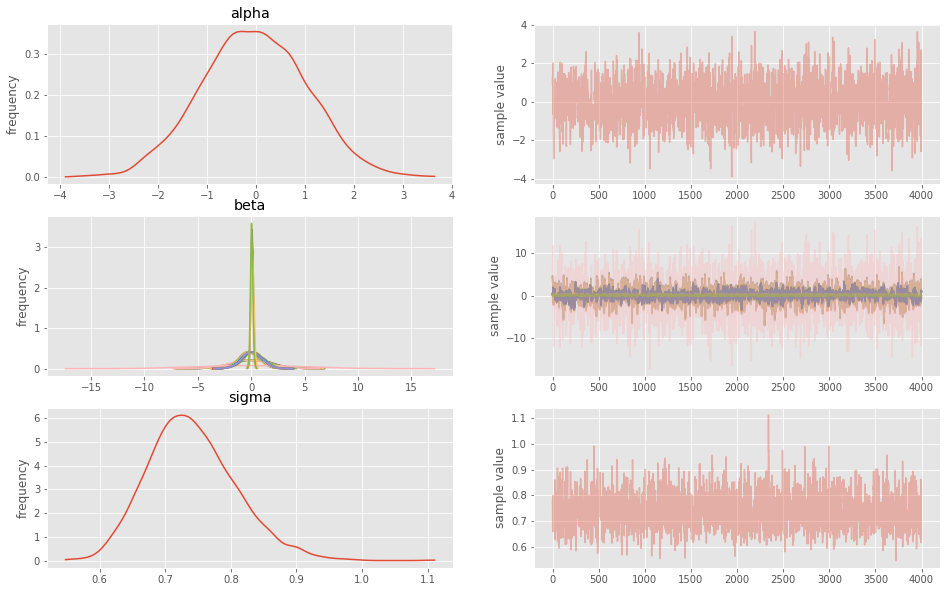

In [17]:
fit.traceplot();

Given the posterior distributions over the variables alpha and beta, we can make predictions for the test set. In this case there are multiple ways to do this! Lets see...

First, recall that the output of STAN consists of samples from the posterior distribution of the latent variables ("parameters" block in the STAN program). We can use these samples to compute the mean (or mode!) of the posterior distribution over alpha and beta ($\hat{\alpha}$ and $\hat{\boldsymbol\beta}$, respectively), and then use that mean/mode to make predictions $\hat{y}$ as follows:

$\hat{y}_n = \hat{\alpha} + \hat{\boldsymbol\beta}^T \textbf{x}_n$

Can you create a vector called "y_hat" with the predictions for the test set?

In [18]:
samples = fit.extract()
alpha_mean = np.mean(samples['alpha'])
#alpha_mode = pystan_utils.posterior_mode(samples['alpha'])
beta_mean  = np.reshape(np.mean(samples['beta'], axis=0), newshape = (D))
#alpha_mode = pystan_utils.posterior_mode(samples['beta'])

In [19]:
y_hat = alpha_mean + np.dot(beta_mean, np.transpose(X_test))

In [20]:
assert y_hat.shape==y_true.shape

Since we standardized the target variable $y$ (number of taxi pickups) before feeding it to the STAN model, we need to convert the predictions back to original scale before evaluating their quality:

In [21]:
# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.708
MAE: 24.216
RMSE: 31.162
R2: 0.485


What we just did for making predictions seems a bit wasteful. STAN just computed for us the (whole!) posterior distribution for alpha and beta, and we completely ignored it by looking at its mean (or mode) and using that to make predictions. Furthermore, why use the mean instead of the mode (or vice-versa)? For sure there must be a better way...

Indeed, the proper Bayesian way of making predictions for our Bayesian linear regression model is to follow the rules of probability. Namely, our goal in prediction is to use the posterior over $\alpha$ and $\boldsymbol\beta$ given the observed data, $p(\alpha | \textbf{y}, \textbf{X})$ and $p(\boldsymbol\beta | \textbf{y}, \textbf{X})$ respectively, to compute the posterior distribution of the target variable $y_*$ for a new input vector $\textbf{x}_*$ as follows:

$p(y_* | \textbf{x}_*, \textbf{y}, \textbf{X}, \sigma) = \int \int \mathcal{N}(y_* | \alpha + \boldsymbol\beta^T \textbf{x}_*, \sigma^2) \, p(\alpha | \textbf{y}, \textbf{X}) \, p(\boldsymbol\beta | \textbf{y}, \textbf{X}) \, d\alpha \, d\boldsymbol\beta$

Notice that we are integrating (or marginalizing) over all values of $\alpha$ and $\boldsymbol\beta$. We can think of this as averaging over the values of $\alpha$ and $\boldsymbol\beta$ according to their posterior distributions.

Since STAN outputs a set of $S$ samples from the posteriors, $\{\alpha^{(s)}, \boldsymbol\beta^{(s)}\}_{s=1}^S$, we can easily use them to approximate the expected value of $y_*$ as follows:

$\mathbb{E}[y_*] \approx \frac{1}{S} \sum_{s=1}^S \alpha^{(s)} + (\boldsymbol\beta^{(s)})^T \textbf{x}_*$

So lets do that!

In [22]:
y_hat = np.mean(samples["alpha"].T + np.dot(X_test, samples["beta"].T), axis=1)

We can evaluate the (new) predictions:

In [23]:
# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.708
MAE: 24.216
RMSE: 31.162
R2: 0.485


Did you get similar error values as before? Probably they didn't change much in this case, because the posteriors of $\alpha$ and $\boldsymbol\beta$ look very Gaussian and also because our likelihood is Gaussian too! But if the posteriors were skewed or multimodal, then this approximation to the Bayesian integral would likely yield quite different results from the ones obtained by using the mean or the mode of the posterior distribution. Therefore, this is something important to be aware of!

### STAN: Train on a slightly larger subset of the data

We will now do inference on a slightly larget subset of the data, and see what happens...

In [21]:
# prepare data for Stan model
X_train_small = X_train[:1000,:]
y_train_small = y_train[:1000]
N, D = X_train_small.shape
data = {'N': N, 'D': D, 'X': X_train_small, 'y': y_train_small}

In [22]:
X_train_small = torch.tensor(X_train_small).float()
y_train_small = torch.tensor(y_train_small).float()

In [23]:
#hmc_kernel = HMC(model)
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)
mcmc.run(X_train_small, y_train_small)
#posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 1100/1100 [07:18,  2.51it/s, step size=1.85e-02, acc. prob=0.949]


In [24]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    alphas     -0.04      0.02     -0.04     -0.07     -0.01    252.28      1.01
   beta[0]     -0.43      1.67     -0.42     -3.26      1.96     40.49      1.01
   beta[1]     -0.35      1.67     -0.35     -3.18      2.04     40.44      1.01
   beta[2]     -0.30      1.67     -0.31     -3.15      2.08     40.47      1.01
   beta[3]     -0.33      1.68     -0.34     -3.21      2.08     40.48      1.01
   beta[4]     -0.31      1.67     -0.33     -3.17      2.06     40.50      1.01
   beta[5]     -0.35      1.67     -0.35     -3.22      2.02     40.50      1.01
   beta[6]     -0.60      1.67     -0.60     -3.44      1.78     40.49      1.01
   beta[7]     -1.13      0.38     -1.10     -1.70     -0.38     17.52      1.00
   beta[8]     -1.24      0.38     -1.21     -1.79     -0.48     17.52      1.00
   beta[9]     -1.34      0.38     -1.31     -1.89     -0.59     17.53      1.00
  beta[10]     -1.37      0

In [25]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition)
fit = sm.sampling(data=data, iter=1000, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9658cf050a8b5c4dc5c3a0b3120eeab5 NOW.


Inference for Stan model: anon_model_9658cf050a8b5c4dc5c3a0b3120eeab5.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     -0.04  6.5e-4   0.02  -0.08  -0.05  -0.04  -0.02 3.9e-4    864    1.0
beta[1]    0.08    0.12    1.8  -3.31  -1.16   0.12   1.31   3.59    233   1.01
beta[2]    0.15    0.12    1.8  -3.23  -1.08   0.19   1.39   3.66    233   1.01
beta[3]     0.2    0.12    1.8  -3.19  -1.02   0.23   1.44   3.72    233   1.01
beta[4]    0.18    0.12   1.81  -3.24  -1.06   0.22   1.43   3.73    233   1.01
beta[5]    0.19    0.12    1.8   -3.2  -1.04   0.23   1.42   3.71    232   1.01
beta[6]    0.16    0.12    1.8  -3.22  -1.07   0.19   1.39   3.67    233   1.01
beta[7]   -0.09    0.12    1.8  -3.49  -1.32  -0.07   1.13   3.41    233   1.01
beta[8]    0.13    0.07   0.99  -1.78  -0.59   0.19   0.77   2.11    179   1.03
beta[9]    0.

Plot the posterior distribution of all the latent variables in the model (alpha, betas and sigma).

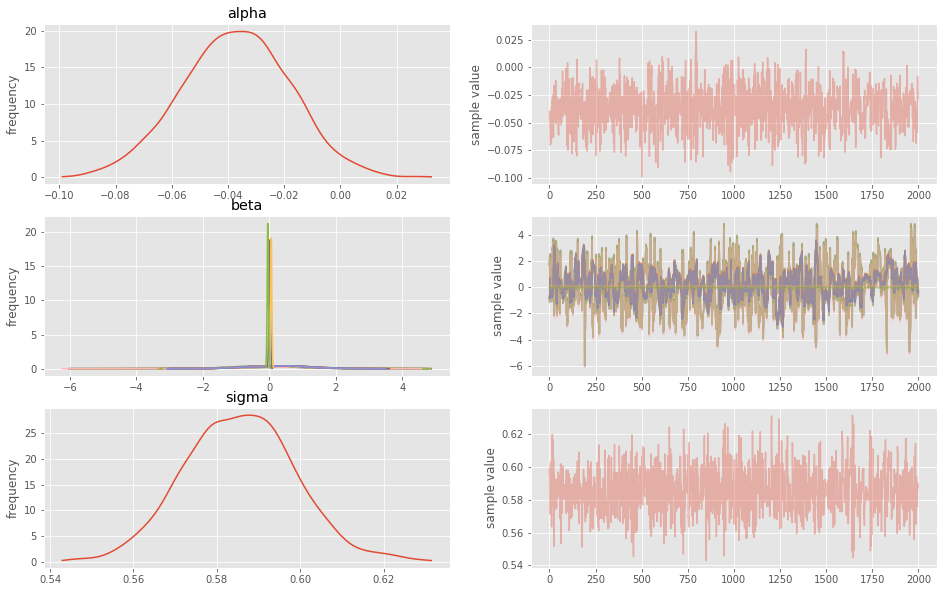

In [26]:
fit.traceplot();

Compare the new posterior distributions with the ones obtained by using only 100 data points from the dataset (above). Be careful with the scales of the plots...

Notice how the model is now much more confident about the posterior distribution of the latent variables in the model (narrower distributions; lower uncertainty in the estimates). This makes sense! The more data we observe, the more confident we become about our estimates.

Now, lets extract the samples from STAN and make predictions for the test set

In [27]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays
y_hat = np.mean(samples["alpha"].T + np.dot(X_test, samples["beta"].T), axis=1)

And lets check the error statistics...

In [28]:
# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.794
MAE: 19.733
RMSE: 26.557
R2: 0.626


Better, right? But this took quite longer to run, and in this case didn't necessarily beat "sklearn"...

MCMC methods have great properties, namely the fact that in the limit of infinite computation time they will converge to the true posterior distribution. However, they often have difficulty scaling to larger datasets. 

### STAN: Train on full dataset using ADVI

ADVI on the other hand is much more scalable. Let us now try to use ADVI to perform inference in our model.

In [29]:
# prepare data for Stan model
N, D = X_train.shape
data = {'N': N, 'D': D, 'X': X_train, 'y': y_train}

In [25]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

In [29]:
# Define the guide
guide = AutoMultivariateNormal(model)

# Define the number of optimization steps
n_steps = 10000

# setup the optimizer
adam_params = {"lr": 0.0005}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(X_train, y_train)
    if step % 100 == 0:
        print('.', end='')

....................................................................................................

In [30]:
%%time
# create Stan model object
fit = sm.vb(data=data, iter=10000, algorithm="fullrank", grad_samples=10, seed=42, verbose=True)

CPU times: user 16.2 s, sys: 58.1 ms, total: 16.3 s
Wall time: 16.2 s


Lets look at the posterior distribution. This is where the "pystan_utils" package that we developed will be useful...

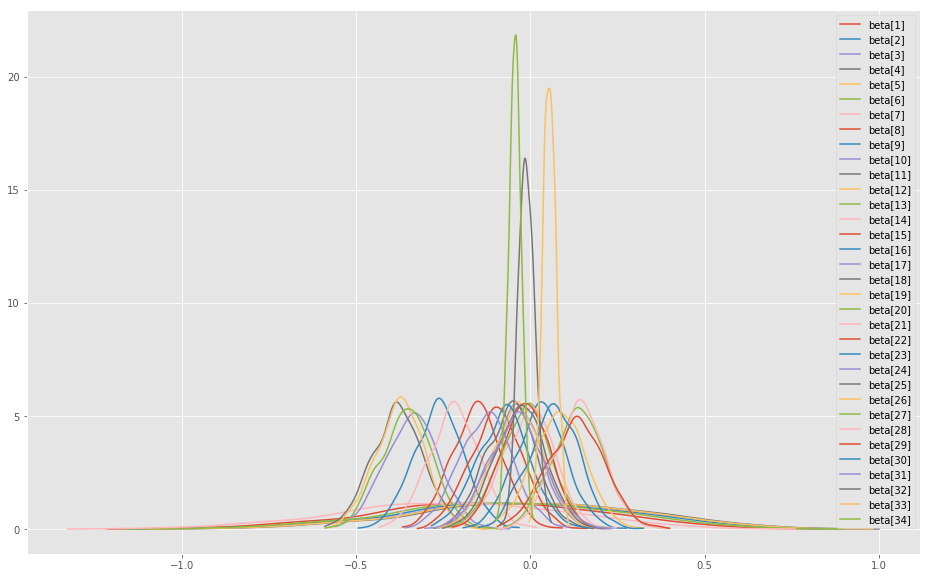

In [31]:
pystan_utils.vb_plot_variables(fit, "beta")

We can also use pystan_utils to extract the mean values of the posteriors:

In [43]:
#svi.guide.get_posterior().loc
#svi.guide.quantiles([0.025, 0.05, 0.25, 0.50, 0.75, 0.95, 0.975])
svi.guide.median()

{'alphas': tensor(-0.0090, grad_fn=<ViewBackward>),
 'beta': tensor([ 0.9650,  1.0446,  1.0868,  1.1041,  1.0799,  1.0089,  0.8623,  0.4729,
          0.3693,  0.2985,  0.2588,  0.2642,  0.2796,  0.4197,  0.5380,  0.6626,
          0.6000,  0.5765,  0.5979,  0.6200,  0.6236,  0.6167,  0.5631,  0.5075,
          0.6082,  0.7184,  0.7789,  0.7660,  0.7634,  0.7043,  0.5983, -0.0113,
          0.0541, -0.0398], grad_fn=<ViewBackward>),
 'sigma': tensor(0.6075, grad_fn=<AddBackward0>)}

In [32]:
alpha = pystan_utils.vb_extract_variable(fit, "alpha", var_type="real")
print("alpha:", alpha)

beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="vector")
print("beta:", beta)

alpha: -0.0052791352418320135
beta: [-0.14114022 -0.05565688 -0.02603473 -0.00723432 -0.02141844 -0.08905005
 -0.2412798  -0.15584722 -0.26550212 -0.34233904 -0.38172463 -0.37635195
 -0.35729199 -0.21907046 -0.09908022  0.02791183 -0.04405014 -0.05865605
 -0.04003955 -0.01730626 -0.00619008 -0.01711532 -0.07918229 -0.12973793
 -0.03107448  0.07870689  0.13420392  0.13766044  0.12791447  0.06575838
 -0.04105519 -0.01132623  0.05438943 -0.04351325]


We also made a more direct way (but more verbose) option for you

In [33]:
pystan_utils.report(fit, 'alpha')
pystan_utils.report(fit, 'beta')

alpha = -0.0052791352418320135
beta[1] = -0.1411402234618472
beta[2] = -0.05565688125874077
beta[3] = -0.02603472784907237
beta[4] = -0.007234315648321484
beta[5] = -0.021418444907928765
beta[6] = -0.08905004732087637
beta[7] = -0.24127980244281166
beta[8] = -0.15584722443939156
beta[9] = -0.2655021165050923
beta[10] = -0.3423390422623705
beta[11] = -0.3817246256606009
beta[12] = -0.3763519466398903
beta[13] = -0.3572919881215466
beta[14] = -0.21907046464356572
beta[15] = -0.09908022216281832
beta[16] = 0.027911831311030415
beta[17] = -0.044050141837450825
beta[18] = -0.058656049991590804
beta[19] = -0.040039549357041196
beta[20] = -0.017306264971781497
beta[21] = -0.006190082892999915
beta[22] = -0.017115323874266876
beta[23] = -0.0791822942476406
beta[24] = -0.1297379330787097
beta[25] = -0.031074480535805832
beta[26] = 0.0787068858225373
beta[27] = 0.13420391773099632
beta[28] = 0.13766044488580784
beta[29] = 0.12791446655524916
beta[30] = 0.06575838262231096
beta[31] = -0.041055187

Using the estimated values, we can make predictions for the test set:

In [34]:
y_hat = alpha + np.dot(X_test, beta)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.803
MAE: 19.317
RMSE: 25.908
R2: 0.644


If we now compare these results with the ones from the "sklearn" package, we can see that we are now doing slightly better...

## 2.2. STAN: Poisson regression

In our previous STAN model, we assumed that the target variable $y$ is Gaussian distributed. However, this might not be the most reasonable choice. Where are modeling the number of taxi pickups (counts!). Perhaps a much more reasonable likelihood is the Poisson distribution:

$y_n \sim \mbox{Poisson}(\exp(\alpha + \boldsymbol\beta^T \textbf{x}_n))$

Notice that we included a log link function to ensure that the rate of the Poisson (the parameter of the Poisson) is non-negative, as required by the definition of the Poisson.

Lets implement this model in STAN!

Hint: STAN offers a more numerically stable version of a Poisson distribution with a log link function (when compared to a naive implementation). Check out the function "poisson_log()" in the documentation!

In [35]:
# define Stan model
model_definition = """
data {
  int<lower=0> N; // shape of data
  int<lower=0> D; // dimensions of x
  matrix[N,D] X;  // feature matrix
  int y[N];      // response vector
}
parameters {
    real          alpha;     // bias
    vector[D]     beta;      // mean parameters
}
model{
    beta  ~ normal(0., 5);
    alpha ~ normal(0., 5);
    
    y ~ poisson(exp(alpha + X*beta));
}
"""

# Compile the model
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb4ad59c4721a00741029c32e33546d1 NOW.


In [48]:
def model_pois(X, obs=None):
    n_betas = X.shape[1]
    alpha = pyro.sample("alphas", dist.Normal(0., 5.))                             # Prior for the bias
    beta  = pyro.sample("beta", dist.Normal(0., 5.).expand([n_betas]).to_event(1)) # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                              # Prior for the variance
    
    lmbda = torch.exp(alpha + X.matmul(beta))
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Poisson(lmbda), obs=obs)
        
    return y

Prepare data for STAN and run inference:

In [36]:
# prepare data for Stan model
N, D = X_train.shape
data = {'N': N, 'D': D, 'X': X_train, 'y': (y_train * y_std + y_mean).astype(np.int)} # y must be original counts

In [37]:
# create Stan model object
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=100, grad_samples=20, seed=42, verbose=True)

In [49]:
# Define the guide
guide = AutoMultivariateNormal(model_pois)

# Define the number of optimization steps
n_steps = 10000

# setup the optimizer
adam_params = {"lr": 0.0005}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(X_train, y_train)
    if step % 100 == 0:
        print('.', end='')

....................................................................................................

In [50]:
svi.guide.median()

{'alphas': tensor(-4.9994, grad_fn=<ViewBackward>),
 'beta': tensor([ 0.9744,  1.0357,  1.0712,  1.1002,  1.0749,  1.0218,  0.8706,  1.8639,
          1.6509, -4.1798, -4.5774, -4.5328, -4.1557,  1.7766,  1.9304,  2.0145,
          1.9750,  1.9496,  1.9637,  1.9926,  1.9870,  1.9834,  1.9344,  1.8994,
          1.9737,  2.0356,  2.0653,  2.0587,  2.0629,  2.0264,  1.9599, -0.0112,
          0.0377, -0.0308], grad_fn=<ViewBackward>),
 'sigma': tensor(4.7988, grad_fn=<AddBackward0>)}

Extract results and compute error statistics:

In [38]:
alpha = pystan_utils.vb_extract_variable(fit, "alpha", var_type="real")
beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="vector")
y_hat = np.exp(alpha + np.dot(X_test, beta))

# convert back to the original scale
preds = y_hat # no need for this one
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.822
MAE: 18.160
RMSE: 24.746
R2: 0.676


Now this is a significative improvement!

By freeing us from predefined standard machine learning algorithms through the use of probability theory, PGMs and approximate Bayesian inference (thanks to STAN, in this case), the model-based machine learning approach gives us the flexibility to develop machine learning models that are specifically tailored to our particular problems! In this case, we know that the target variables is a count (number of taxi pickups), and can revise our model accordingly, so that it encodes our knowledge of the domain.

## 2.3 STAN: Heteroscedastic regression

Ok, let us now assume again that the Gaussian likelihood was indeed the most appropriate choice. In many problems of interest, it is often the case that constant observation variance ($\sigma^2$) is too limiting or inadequate. We can relax this assumption by considering heteroscedastic models, in which the observation variance is assumed to be non-constant and dependent on any other variables. In this particular case, we shall assume that the observation variance is also linearly dependent on the inputs $\textbf{x}$. 

Lets implement this model in STAN (check the lecture slides, if necessary)!

In [39]:
# define Stan model
model_definition = """
data {
  int<lower=0> N; // shape of data
  int<lower=0> D; // dimensions of x
  matrix[N,D] X;  // feature matrix
  real y[N];      // response vector
}
parameters {
    real          alpha_m;   // mean bias
    real          alpha_v;   // variance bias
    vector[D]     beta;      // parameters
    vector[D]     eta;       // variance parameters
}
model{
    beta  ~ normal(0., 5);
    eta   ~ normal(0., 5);
    alpha_m ~ normal(0., 5);
    alpha_v ~ normal(0., 5);
    
    y ~ normal(alpha_m + X*beta, exp(alpha_v + X*eta));
}
"""

# compile model
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_19f19b685a071c612dbdea223a21b4c4 NOW.


In [65]:
def model_heteroscedastic(X, obs=None):
    n_betas = X.shape[1]
    alpha_m = pyro.sample("alpha_m", dist.Normal(0., 5.))                              # Prior for the bias of the mean
    beta_m  = pyro.sample("beta_m", dist.Normal(0., 5.).expand([n_betas]).to_event(1)) # Priors for the regression coeffcients of the mean
    alpha_v = pyro.sample("alpha_v", dist.Normal(0., 5.))                              # Prior for the bias of the variance
    beta_v  = pyro.sample("beta_v", dist.Normal(0., 5.).expand([n_betas]).to_event(1)) # Priors for the coeffcients of the variance
    
    mu    = alpha_m + X.matmul(beta_m)
    sigma = torch.exp(alpha_v + X.matmul(beta_v))
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(mu, sigma), obs=obs)
        
    return y

In [66]:
model_heteroscedastic(X_train).shape

torch.Size([5781])

Prepare data for STAN and run inference:

In [40]:
# prepare data for Stan model
N, D = X_train.shape
data = {'N': N, 'D': D, 'X': X_train, 'y': y_train}

In [1]:
# Define the guide
guide = AutoMultivariateNormal(model_heteroscedastic)

# Define the number of optimization steps
n_steps = 10000

# setup the optimizer
adam_params = {"lr": 0.0005}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(X_train, y_train)
    if step % 100 == 0:
        print('.', end='')

NameError: name 'AutoMultivariateNormal' is not defined

In [69]:
svi.guide.median()

{'alpha_m': tensor(-1.0831, grad_fn=<ViewBackward>),
 'beta_m': tensor([ 1.5963, -1.7465,  2.5388,  1.8865, -1.2316, -0.3310,  1.4041, -0.8296,
          2.2011,  0.1426, -1.9366,  3.2720, -0.9790,  2.5679,  2.5661,  0.6679,
         -1.2734, -0.0425, -1.7241,  0.5344,  0.2269, -1.1374, -1.3562, -1.9589,
         -2.6496, -3.5019, -0.1745,  0.3672,  1.1491,  1.4442, -0.5343,  2.1202,
          1.0358, -1.6883], grad_fn=<ViewBackward>),
 'alpha_v': tensor(0.5656, grad_fn=<ViewBackward>),
 'beta_v': tensor([ 2.7826, -0.5301, -0.6862, -5.1646,  1.8544, -0.4076, -1.0658, -1.0389,
         -0.6675,  0.1948, -2.0080, -0.5481, -1.2252, -1.0224,  2.6974,  1.1601,
          0.4000, -0.1834,  3.8666, -1.5840,  0.8618, -2.2508,  0.7977,  0.7224,
         -0.1047,  0.7091,  0.1250, -0.4166,  1.9726, -1.1611, -3.7160, -2.7850,
         -1.0786, -0.6316], grad_fn=<ViewBackward>)}

In [44]:
%%time
#fit = sm.vb(data=data, iter=1000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)
fit = sm.sampling(data=data, iter=1000, chains=4, algorithm="NUTS", seed=42, verbose=True)

CPU times: user 8.66 s, sys: 2.69 s, total: 11.4 s
Wall time: 1h 58min 28s


In [45]:
#
print(fit)

Inference for Stan model: anon_model_19f19b685a071c612dbdea223a21b4c4.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha_m    0.07  3.2e-4 8.1e-3   0.06   0.07   0.07   0.08   0.09    647   1.01
alpha_v   -0.81  4.3e-4 9.3e-3  -0.83  -0.82  -0.81   -0.8  -0.79    471   1.01
beta[1]   -0.09    0.43   1.94  -3.63  -1.39   -0.1   1.07   3.94     21    1.3
beta[2]   -0.06    0.43   1.94   -3.6  -1.36  -0.07    1.1   3.97     21    1.3
beta[3]   -0.04    0.43   1.94  -3.58  -1.34  -0.05   1.11   3.98     21    1.3
beta[4]   -0.03    0.43   1.95   -3.6  -1.34  -0.04   1.14   4.03     21    1.3
beta[5] -9.0e-3    0.43   1.94  -3.55  -1.31  -0.02   1.15   4.01     21    1.3
beta[6]  7.9e-3    0.43   1.94  -3.53  -1.29-6.7e-3   1.17   4.03     21    1.3
beta[7]   -0.03    0.43   1.94  -3.58  -1.33  -0.04   1.13   3.99     21    1.3
beta[8]  5.8e

Extract results and compute error statistics:

In [47]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays
y_hat = np.mean(samples["alpha_m"].T + np.dot(X_test, samples["beta"].T), axis=1)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.766
MAE: 19.605
RMSE: 28.564
R2: 0.568


In this case, probably you weren't able to improve the results. This is because for this particular problem - taxi pickups - modelling the observation noise as dependent on the inputs $\textbf{x}$ does not make a big difference. But for many problems it does! Think of problems in finance or many problems related to road traffic...

Although the mean predictions of the heteroscedastic model are not better than before, we can now estimate the non-constant observation uncertainty for the data points in the dataset.

In [49]:
sigma_hat = np.mean(np.exp(samples["alpha_m"].T + np.dot(X_test, samples["beta"].T)), axis=1)

In [50]:
len(sigma_hat)

2979

Notice how it changes over time. We can use these values to estimate prediction intervals (e.g. 95% prediction intervals) that are time-varying. Can you think of real-world problems where this information would be useful?